In [1]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-08-07 18:39:35.880608 (PT)


In [2]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract
import copy

In [3]:
model = """
data {
  int<lower=0> K;  // Number of cluster
  int<lower=0> N;  // Number of observations
  real y[N];  // observations
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
  real<lower=0> sigma_shape;
  real<lower=0> sigma_rate;
}

parameters {
  real mu[K]; // cluster means
  // real <lower=0,upper=1> v[K - 1];  // stickbreak components
  vector<lower=0,upper=1>[K - 1] v;  // stickbreak components
  real<lower=0> sigma[K];  // error scale
  real<lower=0> alpha;  // hyper prior DP(alpha, base)
}

transformed parameters {
  simplex[K] eta;
  vector<lower=0,upper=1>[K - 1] cumprod_one_minus_v;

  cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));
  eta[1] = v[1];
  eta[2:(K-1)] = v[2:(K-1)] .* cumprod_one_minus_v[1:(K-2)];
  eta[K] = cumprod_one_minus_v[K - 1];
}

model {
  real ps[K];
  // real alpha = 1;
  
  alpha ~ gamma(alpha_shape, alpha_rate);  // mean = a/b = shape/rate 
  sigma ~ gamma(sigma_shape, sigma_rate);
  mu ~ normal(0, 3);
  v ~ beta(1, alpha);

  for(i in 1:N){
    for(k in 1:K){
      ps[k] = log(eta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(ps);
  }
}

generated quantities {
  real ll;
  real ps_[K];
  
  ll = 0;
  for(i in 1:N){
    for(k in 1:K){
      ps_[k] = log(eta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    ll += log_sum_exp(ps_);
  }  
}
"""

In [4]:
# Compile the model.
%time sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc09797db5631072614538acba641227 NOW.


CPU times: user 875 ms, sys: 51.6 ms, total: 926 ms
Wall time: 52.3 s


In [5]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)
    
# Create data dictionary.
data = dict(y=simdata['y'], K=10, N=len(simdata['y']),
            alpha_shape=1, alpha_rate=10, sigma_shape=1, sigma_rate=10)


In [6]:
def init_prior(model, data, seed=None, iter=10000, adapt_iter=1000):
    prior_data = copy.deepcopy(data)
    prior_data['y'] = []
    prior_data['N'] = 0
    prior_sample = model.vb(data=prior_data, iter=iter, seed=seed, algorithm='meanfield',
                            adapt_iter=adapt_iter, init=0, output_samples=1)
    prior_init = pystan_vb_extract(prior_sample)
    prior_init = dict([(k, prior_init[k][0]) for k in prior_init])
    return prior_init

In [7]:
# Approximate posterior via ADVI
# - ADVI is sensitive to starting values. Should run several times and pick run 
#   that has best fit (e.g. highest ELBO / logliklihood).
# - Variational inference works better with more data. Inference is less accurate
#   with small datasets, due to the variational approximation.

seed_ll = dict()
for seed in range(1, 21):
    prior_init = init_prior(sm, data, seed=seed)
    fit = sm.vb(data=data, iter=1000, seed=seed, algorithm='meanfield', adapt_iter=1000, verbose=False, init=prior_init)
    mean_loglike = pystan_vb_extract(fit)['ll'].mean()
    print("Seed: {} | Mean loglike: {}".format(seed, mean_loglike))
    seed_ll[seed] = mean_loglike

# Print best seed.    
best_seed = sorted(seed_ll.items(), key=lambda k: k[1])[-1][0]
print('Best seed: {}'.format(best_seed))

Seed: 1 | Mean loglike: -296.97534339885004


Seed: 2 | Mean loglike: -279.4981881522244


Seed: 3 | Mean loglike: -296.5818590592196


Seed: 4 | Mean loglike: -297.57368929740204


Seed: 5 | Mean loglike: -298.12935440430334


Seed: 6 | Mean loglike: -215.52033654894672


Seed: 7 | Mean loglike: -282.38671676018913


Seed: 8 | Mean loglike: -298.21808827758196


Seed: 9 | Mean loglike: -297.3955415424155


Seed: 10 | Mean loglike: -296.26039874042584


Seed: 11 | Mean loglike: -297.12619699986857


Seed: 12 | Mean loglike: -299.0439979936928


Seed: 13 | Mean loglike: -296.4168029806117


Seed: 14 | Mean loglike: -272.20748927801867


Seed: 15 | Mean loglike: -297.16401226914337


Seed: 16 | Mean loglike: -297.81969037500784


Seed: 17 | Mean loglike: -277.65662410811296


Seed: 18 | Mean loglike: -297.15100217291354


Seed: 19 | Mean loglike: -299.93172343652486


Seed: 20 | Mean loglike: -277.9467123881065
Best seed: 6


In [8]:
%%time
# Timing: 2.34s / 1000 iterations.
prior_init = init_prior(sm, data, seed=best_seed)
fit = sm.vb(data=data, iter=1000, seed=best_seed,
            algorithm='meanfield', adapt_iter=1000, verbose=False, init=prior_init,
            grad_samples=1, elbo_samples=100, adapt_engaged=True, output_samples=1000)  # anything similar in Turing?

CPU times: user 2.33 s, sys: 4.03 ms, total: 2.33 s
Wall time: 2.32 s


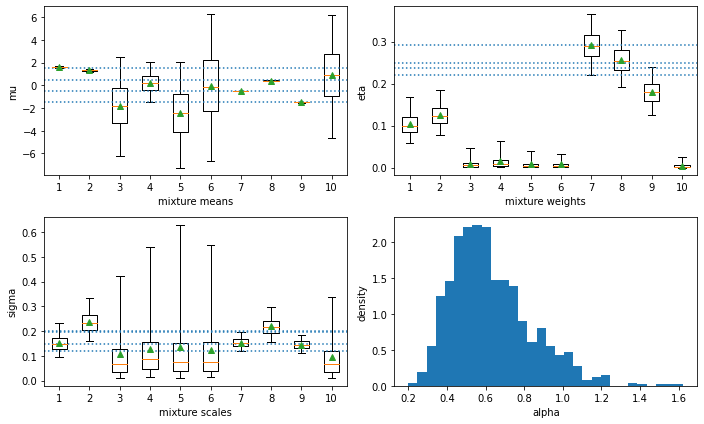

In [9]:
# Plot mu, eta
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.boxplot(pystan_vb_extract(fit)['mu'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('mu')
plt.xlabel('mixture means')
for line in simdata['mu']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 2)
plt.boxplot(pystan_vb_extract(fit)['eta'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('eta')
plt.xlabel('mixture weights')
for line in simdata['w']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 3)
plt.boxplot(pystan_vb_extract(fit)['sigma'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('sigma')
plt.xlabel('mixture scales')
for line in simdata['sig']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 4)
plt.hist(pystan_vb_extract(fit)['alpha'], bins=30, density=True);
plt.xlabel('alpha')
plt.ylabel('density')

plt.tight_layout();

In [10]:
# MCMC setup

# Number of burn in iterations
burn = 500

# Number of sampels to keep
nsamples = 500

# Number of MCMC (HMC / NUTS) iterations in total
niters = burn + nsamples

In [11]:
%%time
# Sample from posterior via HMC: 34s
# NOTE: num_leapfrog = int_time / stepsize.
hmc_fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1,
                  algorithm='HMC', control=dict(stepsize=0.01, int_time=1, adapt_engaged=False))

CPU times: user 23.3 s, sys: 12 ms, total: 23.3 s
Wall time: 23.3 s


In [12]:
%%time
# Sample from posterior via NUTS: 1m 29s
nuts_fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1)

CPU times: user 1min 39s, sys: 93 ms, total: 1min 39s
Wall time: 1min 39s


In [13]:
def plot_param_post(samples, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(samples[param_name], whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=":")

    plt.subplot(1, 2, 2)
    plt.plot(samples[param_name]);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [14]:
def plot_all_params(samples):
    plot_param_post(samples, 'eta', 'mixture weights (eta)', truth=simdata['w'])
    plot_param_post(samples, 'mu', 'mixture means (mu)', truth=simdata['mu'])
    plot_param_post(samples, 'sigma', 'mixture scales (sigma)', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    
    # Plot distribution of alpha
    plt.subplot(1, 2, 1)
    plt.hist(samples['alpha'], bins=30, density=True);
    plt.xlabel('alpha')
    plt.ylabel('density')
    plt.title('Posterior distribution of DP mass parameter (alpha)'); 
    
    # Plot trace of log likelihood (up to proportionality constant)
    plt.subplot(1, 2, 2)
    plt.plot(samples['lp__'])
    plt.xlabel("Iterations (post warmup)")
    plt.ylabel("Log likelihood (scaled)");
    plt.title('Trace plot of log likelihood (scaled)'); 

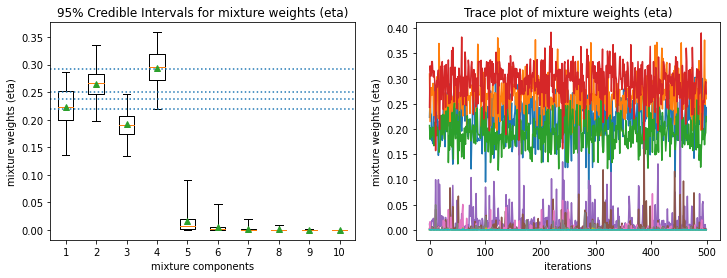

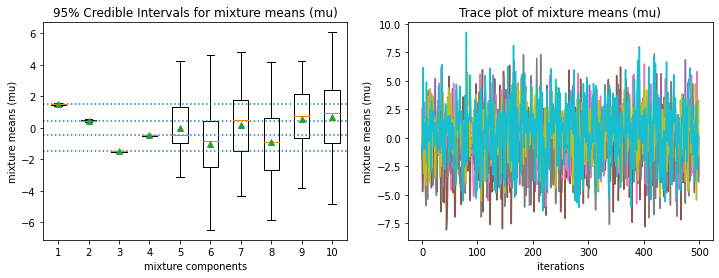

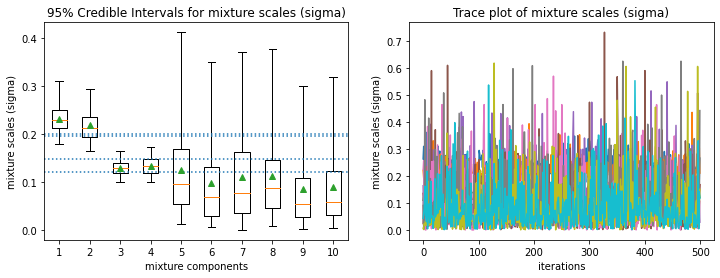

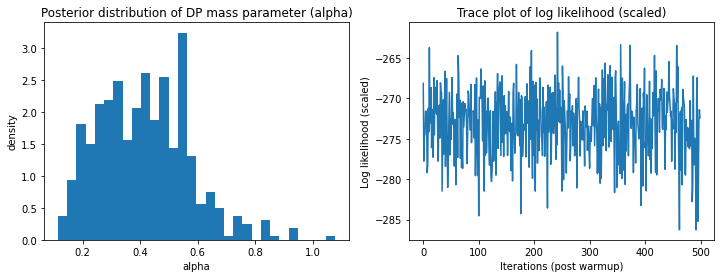

In [15]:
# Plot posterior distribution of parameters under HMC
plot_all_params(hmc_fit)

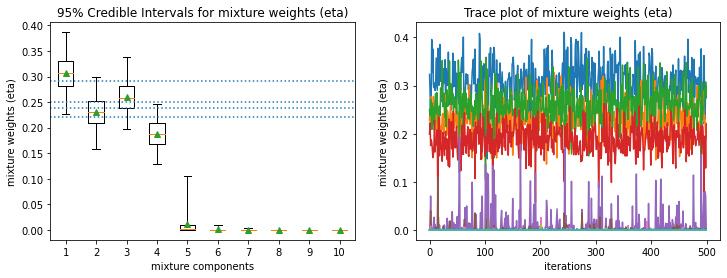

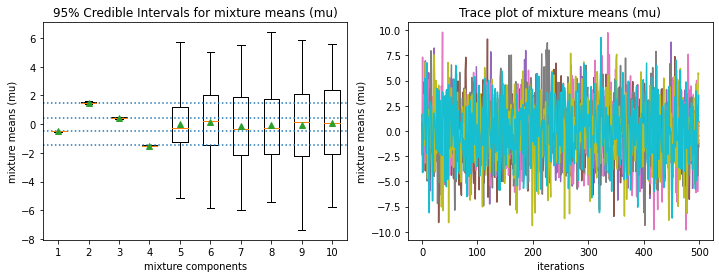

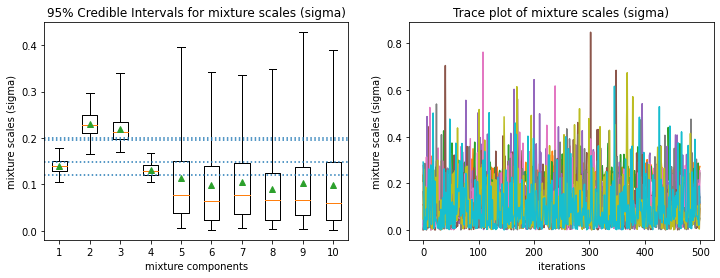

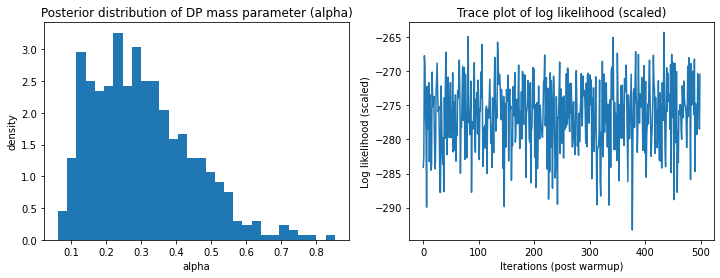

In [16]:
# Plot posterior distribution of parameters under NUTS
plot_all_params(nuts_fit)